In [36]:
!pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [37]:
import os
import base64
import numpy as np
import torch
from torch import nn
from IPython.display import Image, HTML, clear_output
import tqdm
from torch.utils.data import DataLoader, Dataset

from model import CellT, CellGrowingCA, Cell, GrowingCA, AttentionCA, TransformerCell
from model.cell import get_living_mask, get_perception_vector
import utils
clear_output()

In [2]:
def imshow(a, fmt='jpeg'):
  display(Image(data=utils.imencode(a, fmt)))

In [3]:
#@title Cellular Automata Parameters
CHANNEL_N = 16        # Number of CA state channels
TARGET_PADDING = 16   # Number of pixels used to pad the target image border
TARGET_SIZE = 40
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🦎" #@param {type:"string"}

EXPERIMENT_TYPE = "Growing" #@param ["Growing", "Persistent", "Regenerating"]
EXPERIMENT_MAP = {"Growing":0, "Persistent":1, "Regenerating":2}
EXPERIMENT_N = EXPERIMENT_MAP[EXPERIMENT_TYPE]

USE_PATTERN_POOL = [0, 1, 1][EXPERIMENT_N]
DAMAGE_N = [0, 0, 3][EXPERIMENT_N]  # Number of patterns to damage in a batch

In [4]:
# Helpers
def to_rgba(x):
  return x[:,:4,:,:]

def visualize_batch(x0, x, step_i):
  x0 = utils.to_rgb(x0).numpy()
  x = utils.to_rgb(x).numpy()
  print ('X0 shape', x0.shape)
  print('X shape', x.shape)
  vis0 = np.hstack(np.transpose(x0, (0, 2,3,1)))
  vis1 = np.hstack(np.transpose(x, (0,2,3,1)))

  vis = np.vstack([vis0, vis1])
  utils.imwrite('train_log/batches_%04d.jpg'%step_i, vis)
  print('batch (before/after):')
  imshow(vis)


def make_seed(size, n=1):
  x = np.zeros([n, size, size, CHANNEL_N], np.float32)
  x[:, size//2, size//2, 3:] = 1.0
  return x

In [5]:
#@title Choose Target Image { vertical-output: true}
#url = 'https://github.com/google-research/self-organising-systems/blob/master/assets/growing_ca/planaria2_48.png?raw=true'
#target_img = load_image(url, 48)

target_img = utils.load_emoji(TARGET_EMOJI)
# imshow(utils.zoom(utils.to_rgb(target_img), 2), fmt='png')

In [6]:
#@title Initialize Input { vertical-output: true}

p = TARGET_PADDING
target_img_tensor = torch.from_numpy(target_img)

# (72,72,4)
pad_target = torch.nn.functional.pad(target_img_tensor, pad=(0,0,p,p,p,p), mode='constant', value=0)
h, w = pad_target.shape[:2]
# (16, 72, 72)
seed = np.zeros([CHANNEL_N, h, w], np.float32)
seed[3:, h//2, w//2] = 1.0

pad_target = pad_target.permute(2, 0, 1)
print(pad_target.shape)


torch.Size([4, 72, 72])


In [7]:
#@title Models { vertical-output: true}
ca = CellT(
    image_size = 256,
    patch_size = 32,
    num_classes = 1000,
    dim = 1024,
    depth = 4,
    heads = 6,
    mlp_dim = 2048
)

origninal_ca = CellGrowingCA(CHANNEL_N)


In [8]:
# Model In Cell
caModel = Cell(ca)
origninalCAModel = Cell(origninal_ca)

In [9]:
# Training Of Cell
net = GrowingCA(origninalCAModel)

In [10]:
# Assign Model
model = net

In [11]:
# Training Initialize.
loss = nn.MSELoss()

def loss_f(x):
    x = x[:,:4,:,:] # RGB A
    return loss(x, pad_target)
    # return torch.mean(torch.square(to_rgba(x)-pad_target), [-1,-2,-3])

loss_log = []
lr = 2e-3

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1)

pool = utils.SamplePool(x=np.repeat(seed[None, ...], POOL_SIZE, 0))
!mkdir -p train_log && rm -f train_log/*

X0 shape (8, 3, 72, 72)
X shape (8, 3, 72, 72)
batch (before/after):


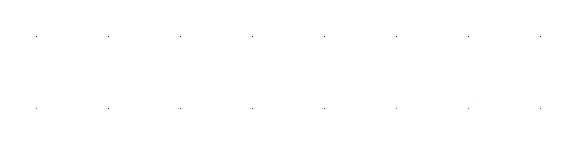

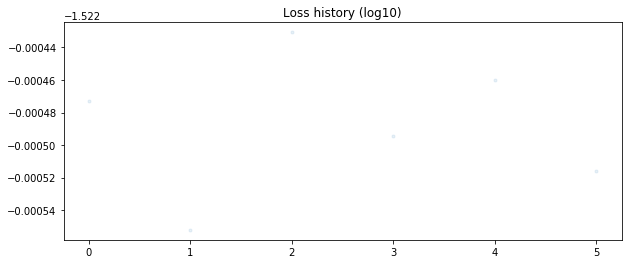

 step: 10, log10(loss): -1.523

In [66]:
model.train()

for i in range(10):
    x0 = np.repeat(seed[None, ...], BATCH_SIZE, 0)
    x0 = torch.Tensor(x0)
    optimizer.zero_grad()

    output = model(x0, 2, 3)
    loss_objective = loss_f(output)
    loss_objective.backward()
    scheduler.step()

    # DISPLAY
    lo_n = loss_objective.detach().numpy()
    o_n = output.detach()
    x0_n = x0.detach()
    
    step_i = len(loss_log)
    loss_log.append(lo_n)
    
    # if step_i%10 == 0:
    #     generate_pool_figures(pool, step_i)
    if step_i%5 == 0:
        clear_output()
        visualize_batch(x0_n, o_n, step_i)
        utils.plot_loss(loss_log)
        # export_model(ca, 'train_log/%04d'%step_i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(lo_n)), end='')

In [12]:
Xx = torch.rand((1,16,72,72))
Yy = torch.rand((4,72,72))
Yyy = torch.tensor(Yy[None,...])
print(Yyy.shape)
Yyyy = Yyy[0]
print(Yyyy.shape)


torch.Size([1, 4, 72, 72])
torch.Size([4, 72, 72])


In [53]:

BATCH_SIZE = 1
alive_target_mask = get_living_mask(pad_target[None,...])

def get_living_target(x):
    living_mask = get_living_mask(x)
    living_target_mask = (living_mask & alive_target_mask)
    living_target = pad_target[None,...] * living_target_mask.float()
    living_target = living_target[0]
    return living_target

def loss_atn_f(x):
    x = x[:,:4,:,:]
    living_target = get_living_target(x)
    return torch.mean(torch.square(x-living_target), [-1,-2,-3])



transformer_cell = TransformerCell(
    num_patches=48,
    patch_size=1,
    channels=1,
    dim = 48,
    depth = 4,
    heads = 3,
    mlp_dim = 48,
    num_classes=16
)  

attentionModel = Cell(transformer_cell)
net = AttentionCA(attentionModel)
model = net


In [47]:
res = loss_atn_f(Xx)
res2 = loss_f(Xx)
print(res)
print(res2)

tensor([0.3202])
tensor(0.3201)


torch.Size([5184, 16])
tensor(True)


In [54]:
current = torch.rand((1,16,72,72))
y = torch.rand((1,4,72,72))

X = torch.reshape(current, (72*72, 16, 1))
Y = torch.reshape(y, (72*72, 4))
print(X.shape)
print(X[0].shape)

reshaped = torch.reshape(X, (1,16,72,72))


eq = torch.all(current.eq(reshaped))
print(eq)



torch.Size([5184, 16, 1])
torch.Size([16, 1])
tensor(True)


In [58]:
class CellDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        print (X.shape, Y.shape)
        assert X.shape[0] == Y.shape[0], 'Dataset X and Y not of same length'
        b = X.shape[0]
        self.length = b

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data = self.X[idx]
        target = self.Y[idx]
        return data, target

model = transformer_cell
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)



In [59]:

model.train()

# TODO 
# 1 - Add to devices
# 2 - extract to own model class so i can just input image and output image. 

EPOCHS = 1
STEPS = 10
loss_log = []

for epoch in range(EPOCHS):
    x0 = np.repeat(seed[None, ...], 1, 0)       # ONLY 1 Starting state (not batched)
    x0 = torch.Tensor(x0) # .to(device)
    x = x0
    for step in range(100):
        # Take each square as a training example and train in batches at each step
        y_target = get_living_target(x)

        percieved = get_perception_vector(x, 16)
        
        # TODO - Add to Device
        X = torch.reshape(percieved, (72*72, 48, 1)) 
        Y = torch.reshape(y_target, (72*72, 4))

        dataset = CellDataset(X=X, Y=Y)

        data_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=False)
        print(data_loader)

        u_x = torch.empty(size=(72*72, 16))
        for batch_i , (data, label) in enumerate(data_loader):
            print('HERE')
            # get output, train, concattente, --> produce new state (x)
            output = model(data)

            c_output = output[:,:4]
            print(c_output.shape)
            loss_objective = criterion(c_output, label)   #TODO - make better loss?

            optimizer.zero_grad()
            loss_objective.backward()
            optimizer.step()
            scheduler.step()
            for i in range(output.shape[0]):
                u_x[(batch_i*64) + i] = output[i]
        
        x = torch.reshape(u_x, (1,16,72,72))

    # DISPLAY results of final loss state. 
    lo_n = loss_objective.cpu().detach().numpy()

    step_i = len(loss_log)
    loss_log.append(lo_n)

    # if step_i%1000 == 0:
    #     generate_pool_figures(pool, step_i)
    if step_i%100 == 0:
        o_n = output.cpu().detach()
        x0_n = x0.cpu().detach()
        clear_output()
        visualize_batch(x0_n, o_n, step_i)
        utils.plot_loss(loss_log)
        # export_model(ca, 'train_log/%04d'%step_i)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(lo_n)), end='')


torch.Size([5184, 48, 1]) torch.Size([5184, 4])
HERE
torch.Size([64, 4])


IndexError: index 64 is out of bounds for dimension 0 with size 64